##Demo for AMS2015

In [65]:
import pyart
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy import ndimage, signal, integrate
import time
import copy
import netCDF4
import skfuzzy as fuzz
%matplotlib inline

In [ ]:
#radar = pyart.io.read('/data/sample_sapr_data/csapr_july9/sgpcsaprsurI7.00.20150709.111301.raw.cfrad.20150709_102911.531_CSAP_v4450_SUR.nc')
radar = pyart.io.read('/Users/scollis/projects/AMS-Short-Course-on-Open-Source-Radar-Software/data/110635.mdv')
i_end = 975
radar.range['data']=radar.range['data'][0:i_end]
for key in radar.fields.keys():
    radar.fields[key]['data']= radar.fields[key]['data'][:, 0:i_end]
radar.ngates = i_end



In [54]:
interp_sonde = netCDF4.Dataset('/data/sgpinterpolatedsondeC1.c1.20110520.000000.cdf')
temperatures = interp_sonde.variables['temp'][:]
times = interp_sonde.variables['time'][:]
heights = interp_sonde.variables['height'][:]
my_profile = pyart.retrieve.fetch_radar_time_profile(interp_sonde, radar)
info_dict = {'long_name': 'Sounding temperature at gate',
             'standard_name' : 'temperature',
             'valid_min' : -100,
             'valid_max' : 100,
             'units' : 'degrees Celsius'}
z_dict, temp_dict = pyart.retrieve.map_profile_to_gates( my_profile['temp'], 
                                         my_profile['height']*1000.0, 
                                         radar)
radar.add_field('sounding_temperature', temp_dict, replace_existing = True)
radar.add_field('height', z_dict, replace_existing = True)
snr = pyart.retrieve.calculate_snr_from_reflectivity(radar)
radar.add_field('SNR', snr, replace_existing = True)

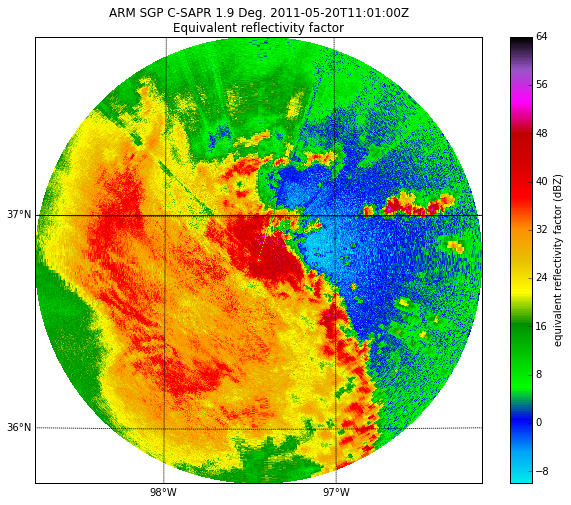

In [2]:
#lets trim some gates
#plt.plot(csapr_radar.fields['reflectivity']['data'][0,975:])


display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 2, resolution = 'i',
                    vmin = -10, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef)

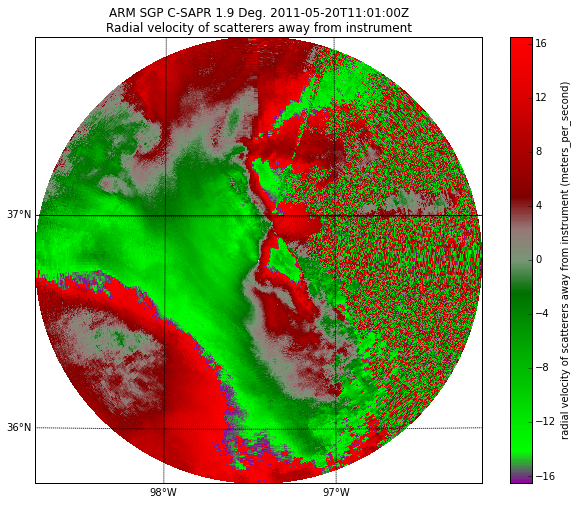

In [40]:
nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('velocity', sweep = 2, resolution = 'i',
                    vmin = -nyq, vmax = nyq, mask_outside = False,
                    cmap = pyart.graph.cm.NWSVel)

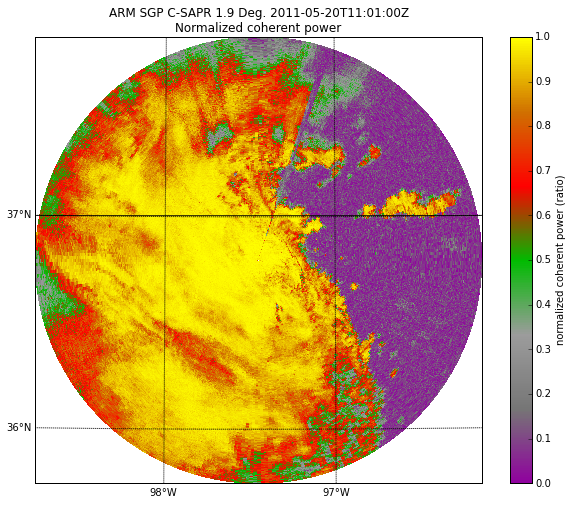

In [4]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('normalized_coherent_power', sweep = 2, resolution = 'i',
                    vmin = 0, vmax = 1, mask_outside = False,
                    cmap = pyart.graph.cm.NWS_SPW)


In [5]:
start_time = time.time()
data = ndimage.filters.generic_filter(radar.fields['velocity']['data'],
                                            pyart.util.interval_std, size = (4,4),
                                           extra_arguments = (-nyq, nyq))
total_time = time.time() - start_time
print(total_time)

219.023764849


In [6]:
filtered_data = ndimage.filters.median_filter(data, size = (4,4))
texture_field = pyart.config.get_metadata('velocity')
texture_field['data'] = filtered_data
radar.add_field('velocity_texture', texture_field, replace_existing = True)

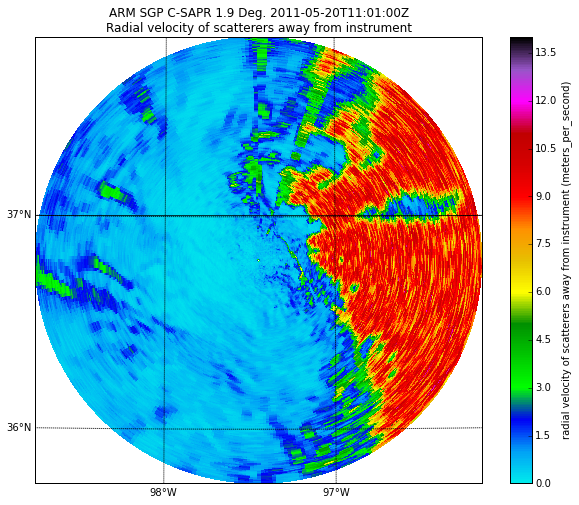

In [7]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('velocity_texture', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = 0, vmax = 14)

In [8]:
n, bins = np.histogram(filtered_data.flatten(), bins = 150)
peaks = signal.find_peaks_cwt(n, np.array([10]))
centers = bins[0:-1] + (bins[1] - bins[0])
search_data = n[peaks[0]:peaks[1]]
search_centers = centers[peaks[0]:peaks[1]]
locs = search_data.argsort()
location_of_minima = locs[0]

5.66092710773


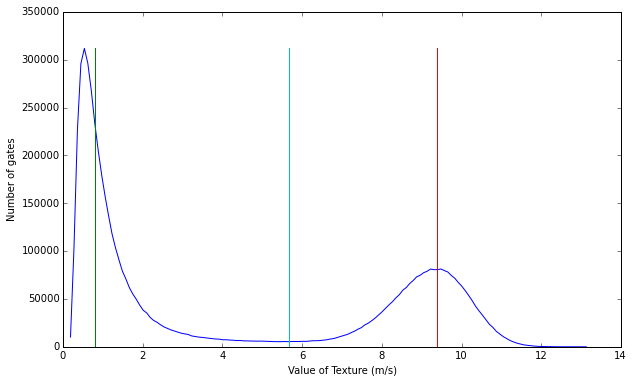

In [9]:
fig = plt.figure(figsize = [10,6])
plt.plot(centers, n)
zmax = n.max()
plt.plot([centers[peaks[0]], centers[peaks[0]]], [0, zmax])
plt.plot([centers[peaks[1]], centers[peaks[1]]], [0, zmax])
plt.plot([search_centers[location_of_minima], search_centers[location_of_minima]], [0, zmax])
noise_threshold = search_centers[locs[0]]
print(noise_threshold)
plt.xlabel('Value of Texture (m/s)')
plt.ylabel('Number of gates')

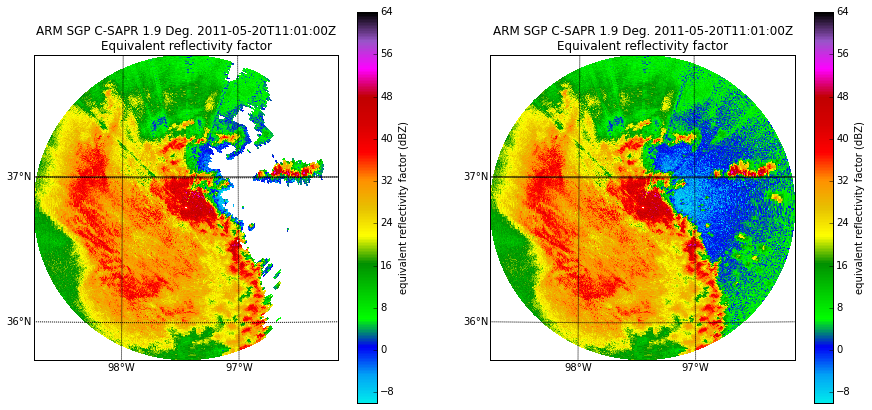

In [10]:
likely_noise = filtered_data > noise_threshold
likely_signal = np.logical_not(likely_noise)

z_masked = np.ma.masked_where(likely_noise, radar.fields['reflectivity']['data'])
radar.add_field_like('reflectivity', 
                     'reflectivity_masked', 
                     z_masked, replace_existing = True)
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [15,7])
plt.subplot(1,2,1)
display.plot_ppi_map('reflectivity_masked', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)
plt.subplot(1,2,2)
display.plot_ppi_map('reflectivity', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)

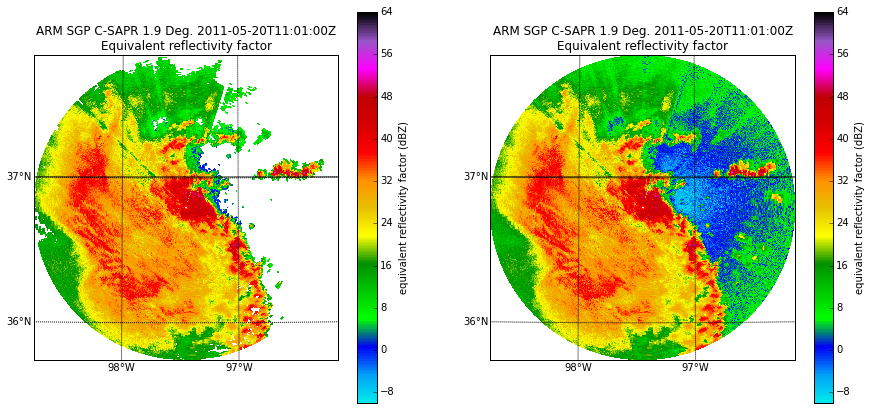

In [11]:
likely_noise = radar.fields['normalized_coherent_power']['data'] < .5
likely_signal = np.logical_not(likely_noise)

z_masked = np.ma.masked_where(likely_noise, radar.fields['reflectivity']['data'])
radar.add_field_like('reflectivity', 
                     'reflectivity_masked2', 
                     z_masked, replace_existing = True)
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [15,7])
plt.subplot(1,2,1)
display.plot_ppi_map('reflectivity_masked2', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)
plt.subplot(1,2,2)
display.plot_ppi_map('reflectivity', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)

In [12]:
gatefilter = pyart.correct.GateFilter(radar)
gatefilter.exclude_masked('reflectivity_masked')
corr_vel = pyart.correct.dealias_region_based(
    radar, vel_field='velocity', keep_original=False, 
    gatefilter = gatefilter, nyquist_vel=nyq, centered = True)
radar.add_field('corrected_velocity', corr_vel, replace_existing = True)

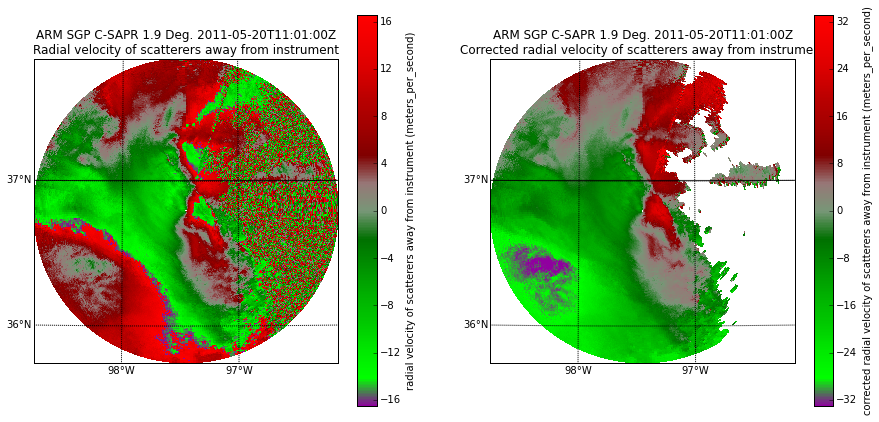

In [13]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [15,7])
plt.subplot(1,2,1)
display.plot_ppi_map('velocity', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSVel,
                    vmin = -nyq, vmax = nyq)
plt.subplot(1,2,2)
display.plot_ppi_map('corrected_velocity', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSVel,
                    vmin = -2*nyq, vmax = 2*nyq)

In [152]:
phidp, kdp = pyart.correct.phase_proc_lp(radar, 0.0, debug=True, fzl=3500.0)

Unfolding
Exec time:  16.1573240757
Doing  0
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:183: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer n

 1
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 2
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 3
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 4
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 5
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 6
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 7
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 8
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 9
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 10
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 11
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 12
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 13
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 14
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 15
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 16


/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

In [154]:
radar.add_field('corrected_differential_phase', phidp,replace_existing = True)
radar.add_field('corrected_specific_diff_phase', kdp,replace_existing = True)
fakephidp = np.zeros_like(radar.fields['corrected_specific_diff_phase']['data'])

moo = copy.deepcopy(radar.fields['corrected_specific_diff_phase']['data'])
moo[radar.fields['corrected_specific_diff_phase']['data'] > 15.0] = 15.0
new_phidp = integrate.cumtrapz(moo,
                               radar.range['data'], axis=1)
fakephidp[:,0:-1]= new_phidp
radar.add_field_like('corrected_differential_phase', 'corrected_differential_phase_2', 
                     fakephidp/500.,replace_existing = True)
spec_at, cor_z = pyart.correct.calculate_attenuation(
    radar, 0, refl_field='reflectivity_masked',
    ncp_field='normalized_coherent_power', rhv_field='cross_correlation_ratio',
    phidp_field='corrected_differential_phase_2')
radar.add_field('specific_attenuation', spec_at, replace_existing = True)
radar.add_field('corrected_reflectivity_horizontal', cor_z, replace_existing = True)
fakeintA = np.zeros_like(radar.fields['specific_attenuation']['data'])

moo = copy.deepcopy(radar.fields['specific_attenuation']['data'])
new_A = integrate.cumtrapz(moo,
                               radar.range['data'], axis=1)
fakeintA[:,0:-1]= new_A
radar.add_field_like('corrected_reflectivity_horizontal', 'corrected_reflectivity_horizontal_2', 
                     fakeintA/500. + radar.fields['reflectivity_masked']['data'],replace_existing = True)

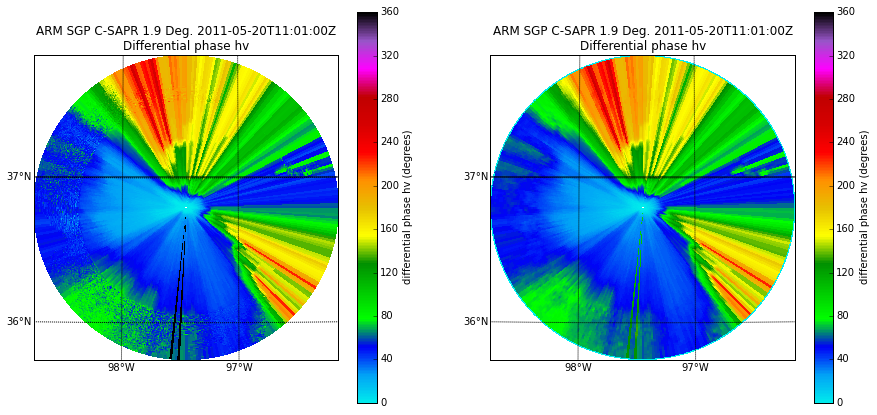

In [156]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [15,7])
plt.subplot(1,2,1)
display.plot_ppi_map('corrected_differential_phase', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = 0, vmax = 360)
plt.subplot(1,2,2)
display.plot_ppi_map('corrected_differential_phase_2', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = 0, vmax = 360)


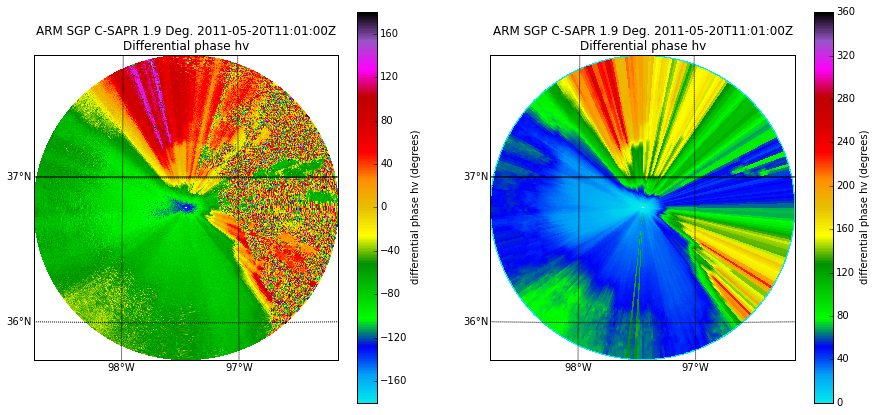

In [157]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [15,7])
plt.subplot(1,2,1)
display.plot_ppi_map('differential_phase', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -180, vmax = 180)
plt.subplot(1,2,2)
display.plot_ppi_map('corrected_differential_phase_2', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = 0, vmax = 360)


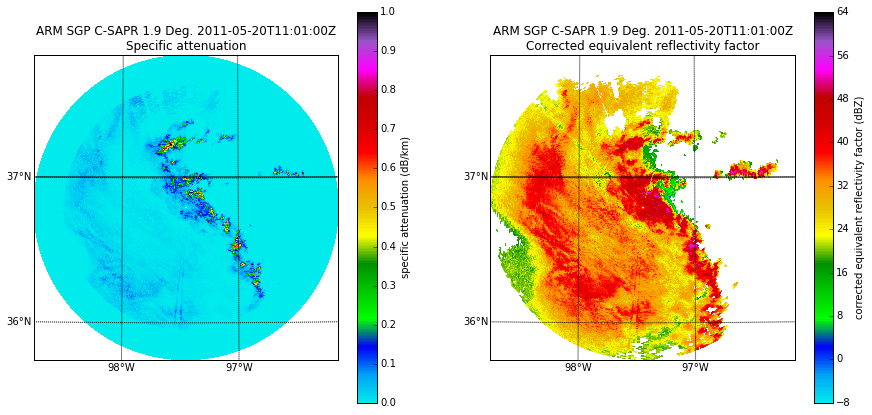

In [158]:
fig = plt.figure(figsize = [15,7])
display = pyart.graph.RadarMapDisplay(radar)
plt.subplot(1,2,1)
display.plot_ppi_map('specific_attenuation', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = 0, vmax = 1)
plt.subplot(1,2,2)
display.plot_ppi_map('corrected_reflectivity_horizontal', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -8, vmax = 64)

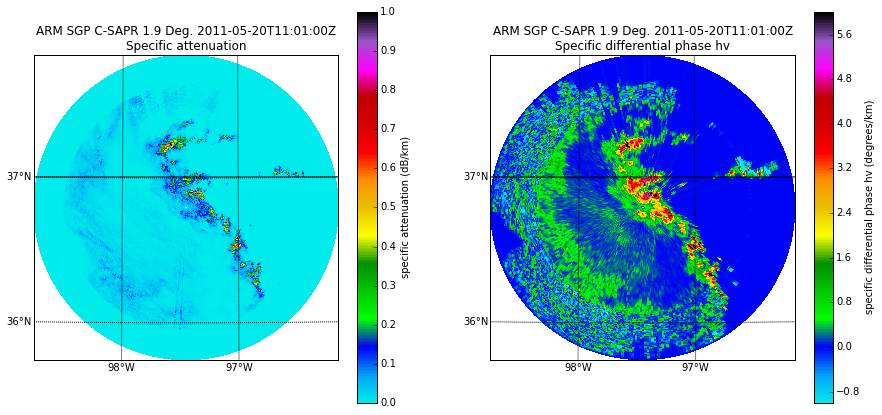

In [159]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [15,7])
plt.subplot(1,2,1)
display.plot_ppi_map('specific_attenuation', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = 0, vmax = 1)
plt.subplot(1,2,2)
display.plot_ppi_map('corrected_specific_diff_phase', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -1, vmax = 6)

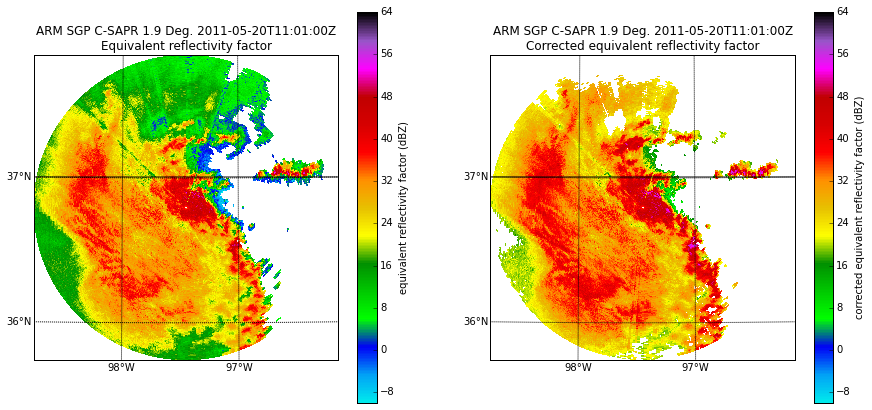

In [160]:
fig = plt.figure(figsize = [15,7])

display = pyart.graph.RadarMapDisplay(radar)
plt.subplot(1,2,1)
display.plot_ppi_map('reflectivity_masked', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)
plt.subplot(1,2,2)
display.plot_ppi_map('corrected_reflectivity_horizontal', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)

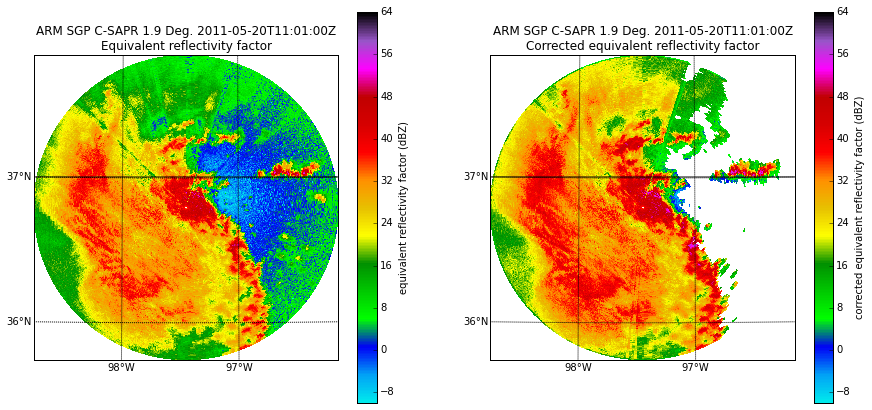

In [162]:
fig = plt.figure(figsize = [15,7])

display = pyart.graph.RadarMapDisplay(radar)
plt.subplot(1,2,1)
display.plot_ppi_map('reflectivity', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)
plt.subplot(1,2,2)
display.plot_ppi_map('corrected_reflectivity_horizontal_2', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)

In [24]:

grids = pyart.map.grid_from_radars(
         (radar,), grid_shape=(52, 401, 401),
        grid_limits=((0, 17000.0),(-120000, 120000), (-120000, 120000)),
        fields=radar.fields.keys(), gridding_algo="map_gates_to_grid",
        weighting_function='BARNES')


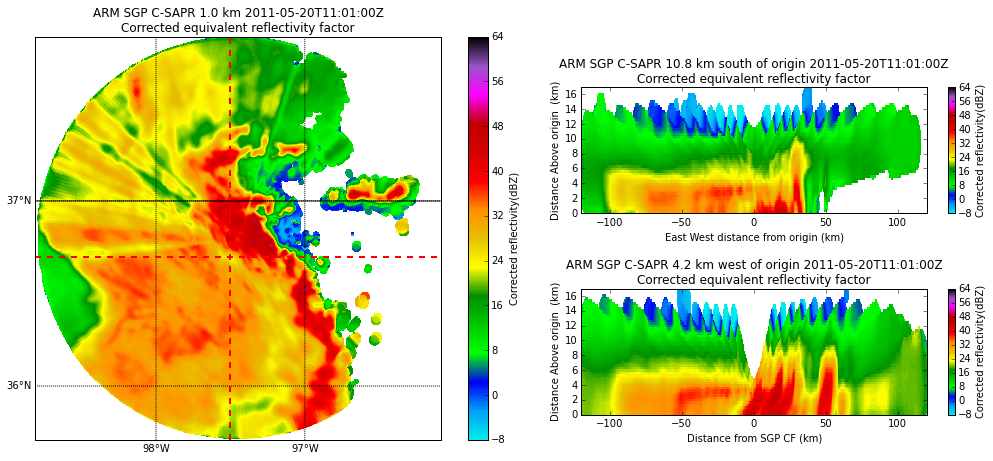

In [38]:
display = pyart.graph.GridMapDisplay(grids)
fig = plt.figure(figsize=[15, 7])

# panel sizes
map_panel_axes = [0.05, 0.05, .5, .80]
x_cut_panel_axes = [0.58, 0.10, .4, .25]
y_cut_panel_axes = [0.58, 0.50, .4, .25]

# parameters
level = 3 #21
vmin = -8
vmax = 64
lat = 36.7
lon = -97.5

# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = np.arange(-104, -93, 1) )
display.plot_grid('corrected_reflectivity_horizontal_2', level=level, vmin=vmin, vmax=vmax,
                 cmap = pyart.graph.cm.NWSRef)
display.plot_crosshairs(lon=lon, lat=lat)

# panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('corrected_reflectivity_horizontal_2', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                            cmap = pyart.graph.cm.NWSRef)
ax2.set_ylim([0,17])
ax2.set_xlim([-120,120])

ax2.set_xlabel('Distance from SGP CF (km)')

# panel 3, latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
ax3.set_ylim([0,17])
ax3.set_xlim([-120,120])

display.plot_latitude_slice('corrected_reflectivity_horizontal_2', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                           cmap = pyart.graph.cm.NWSRef)



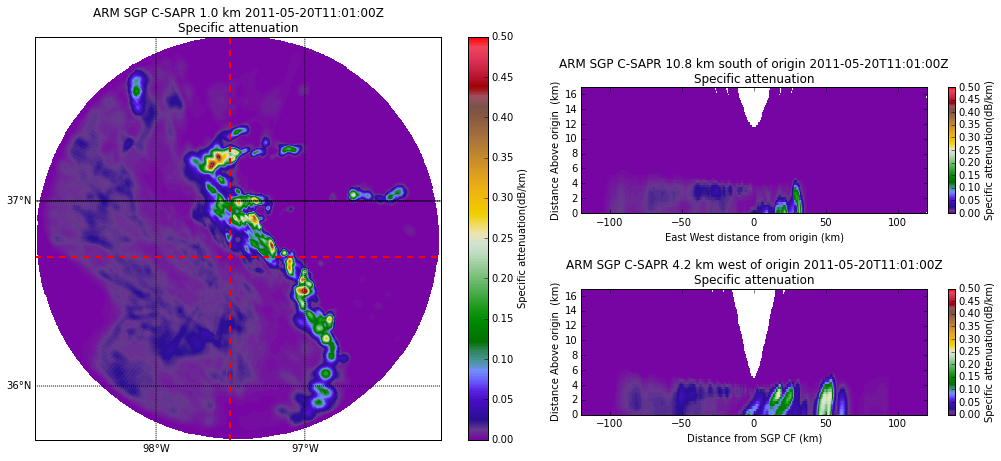

In [163]:
display = pyart.graph.GridMapDisplay(grids)
fig = plt.figure(figsize=[15, 7])
vmin = 0
vmax = 0.5
# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = np.arange(-104, -93, 1) )
display.plot_grid('specific_attenuation', level=level, vmin=vmin, vmax=vmax,
                 cmap = pyart.graph.cm.Carbone42)
display.plot_crosshairs(lon=lon, lat=lat)

# panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('specific_attenuation', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                            cmap = pyart.graph.cm.Carbone42)
ax2.set_ylim([0,17])
ax2.set_xlim([-120,120])

ax2.set_xlabel('Distance from SGP CF (km)')

# panel 3, latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
ax3.set_ylim([0,17])
ax3.set_xlim([-120,120])

display.plot_latitude_slice('specific_attenuation', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                           cmap = pyart.graph.cm.Carbone42)



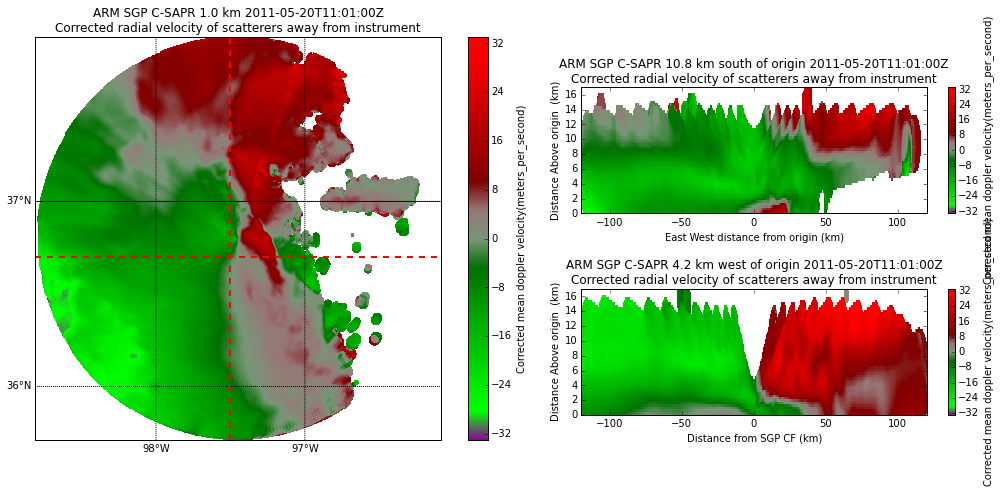

In [49]:
display = pyart.graph.GridMapDisplay(grids)
fig = plt.figure(figsize=[15, 7])
vmin = -nyq*2.0
vmax = nyq*2.0
# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = np.arange(-104, -93, 1) )
display.plot_grid('corrected_velocity', level=level, vmin=vmin, vmax=vmax,
                 cmap = pyart.graph.cm.NWSVel)
display.plot_crosshairs(lon=lon, lat=lat)

# panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('corrected_velocity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                            cmap = pyart.graph.cm.NWSVel)
ax2.set_ylim([0,17])
ax2.set_xlim([-120,120])

ax2.set_xlabel('Distance from SGP CF (km)')

# panel 3, latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
ax3.set_ylim([0,17])
ax3.set_xlim([-120,120])

display.plot_latitude_slice('corrected_velocity', lon=lon, lat=lat, vmin=vmin, vmax=vmax,
                           cmap = pyart.graph.cm.NWSVel)



In [50]:
#moment : [[start_up, finish_up, start_down, finish_down], weight]
def cum_score_fuzzy_logic(radar, mbfs = None, 
                          debug = False, ret_scores = False,
                          hard_const = None):
    if mbfs == None:
        second_trip = {'velocity_texture' : [[0,0,80,90], 1.0], 
                       'cross_correlation_ratio' : [[.5,.7,1,1], 0.0], 
                       'normalized_coherent_power' : [[0,0,.5,.6], 3.0], 
                       'height': [[0,0,5000,8000], 1.0], 
                       'sounding_temperature' : [[-100,-100,100,100], 0.0],
                       'SNR' : [[15,20, 1000,1000],1.0]}

        rain = {'differential_phase_texture' : [[0,0,80,90], 1.0], 
                       'cross_correlation_ratio' : [[0.94,0.96,1,1], 1.0], 
                       'normalized_coherent_power' : [[0.4,0.5,1,1], 1.0], 
                       'height': [[0,0,5000,6000], 0.0], 
                       'sounding_temperature' : [[0,3,100,100], 2.0],
                       'SNR' : [[8,10, 1000,1000], 1.0]}

        snow = {'differential_phase_texture' : [[0,0,80,90], 1.0], 
                       'cross_correlation_ratio' : [[0.85,0.9,1,1], 1.0], 
                       'normalized_coherent_power' : [[0.4,0.5,1,1], 1.0], 
                       'height': [[0,0,25000,25000], 0.0], 
                       'sounding_temperature' : [[-100,-100,0,1.], 2.0],
                       'SNR' : [[8,10, 1000,1000], 1.0]}

        no_scatter = {'differential_phase_texture' : [[90,90,400,400], 0.0], 
                       'cross_correlation_ratio' : [[0,0,0.1,0.2], 0.0], 
                       'normalized_coherent_power' : [[0,0,0.1,0.2], 0.0], 
                       'height': [[0,0,25000,25000], 0.0], 
                       'sounding_temperature' : [[-100,-100,100,100], 0.0],
                       'SNR' : [[-100,-100, 8,10], 6.0]}
        
        melting = {'differential_phase_texture' : [[20,30,80,90], 0.0], 
                       'cross_correlation_ratio' : [[0.6,0.7,.94,.96], 4.], 
                       'normalized_coherent_power' : [[0.4,0.5,1,1], 0], 
                       'height': [[0,0,25000,25000], 0.0], 
                       'sounding_temperature' : [[-1.,0,3.5,5], 2.],
                       'SNR' : [[8,10, 1000,1000], 0.0]}

        mbfs = {'multi_trip': second_trip, 'rain' : rain, 
                'snow' :snow, 'no_scatter' : no_scatter, 'melting' : melting}
    flds = radar.fields
    scores = {}
    for key in mbfs.keys():
        if debug: print('Doing ' + key)
        this_score = np.zeros(flds[flds.keys()[0]]['data'].shape).flatten() * 0.0
        for MBF in mbfs[key].keys():
            this_score = fuzz.trapmf(flds[MBF]['data'].flatten(), 
                                     mbfs[key][MBF][0] )*mbfs[key][MBF][1] + this_score

        this_score = this_score.reshape(flds[flds.keys()[0]]['data'].shape)
        scores.update({key: ndimage.filters.median_filter(this_score, size = [3,4])})
    if hard_const != None:
        # hard_const = [[class, field, (v1, v2)], ...]
        for this_const in hard_const:
            if debug: print('Doing hard constraining ', this_const[0])
            key = this_const[0]
            const = this_const[1]
            fld_data = radar.fields[const]['data']
            lower = this_const[2][0]
            upper = this_const[2][1]
            const_area = np.where(np.logical_and(fld_data >= lower, fld_data <= upper))
            if debug: print(const_area)
            scores[key][const_area] = 0.0
    stacked_scores = np.dstack([scores[key] for key in scores.keys() ])  
    #sum_of_scores = stacked_scores.sum(axis = 2)
    #print(sum_of_scores.shape)
    #norm_stacked_scores = stacked_scores
    max_score = stacked_scores.argmax(axis = 2)

    gid = {}
    gid['data'] = max_score
    gid['units'] = ''
    gid['standard_name'] = 'gate_id'

    strgs = ''
    i=0
    for key in scores.keys():
        strgs = strgs + str(i) + ': ' + key + ' '

    gid['long_name'] = 'Classification of dominant scatterer'
    gid['notes'] = strgs
    gid['valid_max'] = max_score.max()
    gid['valid_min'] = 0.0 
    if ret_scores == False:
        rv = (gid, scores.keys())
    else:
        rv = (gid, scores.keys(), scores)
    return rv

In [140]:
#moment : [[start_up, finish_up, start_down, finish_down], weight]

second_trip = {'velocity_texture' : [[5.,6.,130.,130.], 5.0], 
               'cross_correlation_ratio' : [[.5,.7,1,1], 0.0], 
               'normalized_coherent_power' : [[0,0,.5,.6], 0.0], 
               'height': [[0,0,5000,8000], 0.0], 
               'sounding_temperature' : [[-100,-100,100,100], 0.0],
               'SNR' : [[15,20, 1000,1000],1.0]}

rain = {'velocity_texture' : [[0,0,4,6], 1.0], 
               'cross_correlation_ratio' : [[0.97,0.98,1,1], 1.0], 
               'normalized_coherent_power' : [[0.4,0.5,1,1], 1.0], 
               'height': [[0,0,5000,6000], 0.0], 
               'sounding_temperature' : [[2.,5.,100,100], 2.0],
               'SNR' : [[8,10, 1000,1000], 1.0]}

snow = {'velocity_texture' : [[0,0,4,6], 1.0], 
               'cross_correlation_ratio' : [[0.65,0.9,1,1], 1.0], 
               'normalized_coherent_power' : [[0.4,0.5,1,1], 1.0], 
               'height': [[0,0,25000,25000], 0.0], 
               'sounding_temperature' : [[-100,-100,.5,4.], 2.0],
               'SNR' : [[8,10, 1000,1000], 1.0]}

no_scatter = {'velocity_texture' : [[4.,5.,30.,30.], 2.0], 
               'cross_correlation_ratio' : [[0,0,0.1,0.2], 0.0], 
               'normalized_coherent_power' : [[0,0,0.1,0.2], 0.0], 
               'height': [[0,0,25000,25000], 0.0], 
               'sounding_temperature' : [[-100,-100,100,100], 0.0],
               'SNR' : [[-100,-100, 8,10], 4.0]}

melting = {'velocity_texture' : [[0,0,4,6], 1.5], 
               'cross_correlation_ratio' : [[0.6,0.65,.9,.96], 3.5], 
               'normalized_coherent_power' : [[0.4,0.5,1,1], 0], 
               'height': [[0,0,25000,25000], 0.0], 
               'sounding_temperature' : [[0,0.5,6,7], 1.],
               'SNR' : [[8,10, 1000,1000], 0.0]}

mbfs = {'multi_trip': second_trip, 'rain' : rain, 
        'snow' :snow, 'no_scatter' : no_scatter, 'melting' : melting}

hard_const = [['melting' , 'sounding_temperature', (10, 100)],
              ['multi_trip', 'height', (10000, 1000000)],
              ['melting' , 'sounding_temperature', (-10000, -2)]]


In [141]:
gid_fld, cats = cum_score_fuzzy_logic(radar, mbfs = mbfs, debug = True, hard_const = hard_const)

Doing no_scatter
Doing melting
Doing multi_trip
Doing rain
Doing snow
('Doing hard constraining ', 'melting')
(masked_array(data = [   0    0    0 ..., 6119 6119 6119],
             mask = False,
       fill_value = -9999.0)
, masked_array(data = [ 0  1  2 ..., 26 27 28],
             mask = False,
       fill_value = -9999.0)
)
('Doing hard constraining ', 'multi_trip')
(array([1800, 1800, 1800, ..., 6119, 6119, 6119]), array([966, 967, 968, ..., 972, 973, 974]))
('Doing hard constraining ', 'melting')
(masked_array(data = [ 720  720  720 ..., 6119 6119 6119],
             mask = False,
       fill_value = -9999.0)
, masked_array(data = [893 894 895 ..., 972 973 974],
             mask = False,
       fill_value = -9999.0)
)


In [142]:
def fix_rain_above_bb(gid_fld, rain_class, melt_class, snow_class):
    new_gid = copy.deepcopy(gid_fld)
    for ray_num in range(new_gid['data'].shape[0]):
        if melt_class in new_gid['data'][ray_num, :]:
            max_loc = np.where(new_gid['data'][ray_num, :] == melt_class)[0].max()
            rain_above_locs = np.where(new_gid['data'][ray_num, max_loc:] == rain_class)[0] + max_loc
            new_gid['data'][ray_num, rain_above_locs] = snow_class
    return new_gid

In [143]:
radar.add_field('gate_id', fix_rain_above_bb(gid_fld, 3, 1, 5), 
                      replace_existing = True)

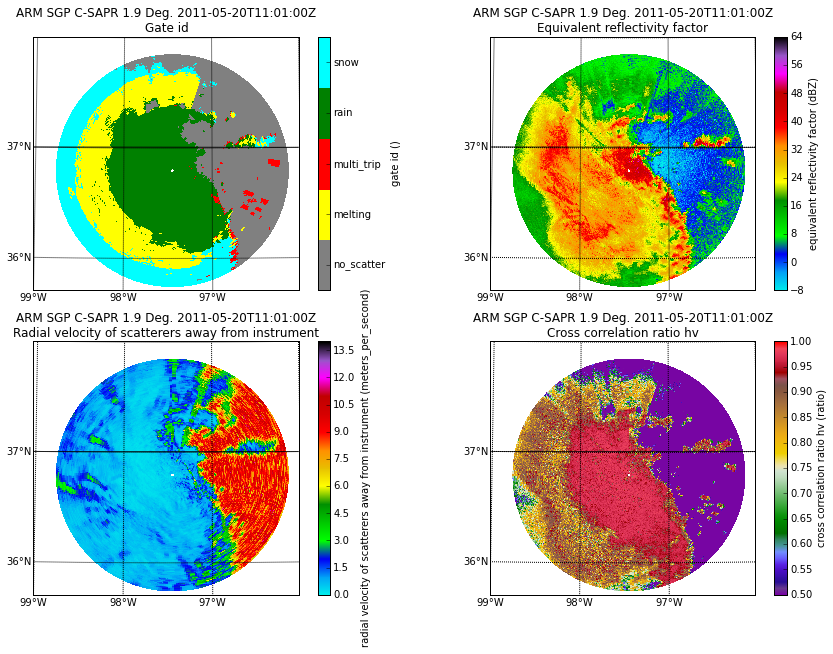

In [145]:
min_lon=-99.
max_lon=-96.
min_lat=35.7
max_lat=38.
lon_lines=[-95, -96, -97, -98, -99]
lat_lines=[35,36,37,38]

display = pyart.graph.RadarMapDisplay(radar)

f = plt.figure(figsize = [15,10])
plt.subplot(2, 2, 1) 
lab_colors=['gray','yellow', 'red', 'green', 'cyan' ]
cmap = matplotlib.colors.ListedColormap(lab_colors)
display.plot_ppi_map('gate_id', sweep = 2, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = cmap, vmin = 0, vmax = 5)
cbax=plt.gca()
#labels = [item.get_text() for item in cbax.get_xticklabels()]
#my_display.cbs[-1].ax.set_yticklabels(cats)
tick_locs   = np.linspace(0,len(cats) -1 ,len(cats))+0.5
display.cbs[-1].locator     = matplotlib.ticker.FixedLocator(tick_locs)
display.cbs[-1].formatter   = matplotlib.ticker.FixedFormatter(cats)
display.cbs[-1].update_ticks()
plt.subplot(2, 2, 2) 
display.plot_ppi_map('reflectivity', sweep = 2, vmin = -8, vmax = 64,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = pyart.graph.cm.NWSRef)

plt.subplot(2, 2, 3) 
display.plot_ppi_map('velocity_texture', sweep = 2, vmin =0, vmax = 14, 
                     min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = pyart.graph.cm.NWSRef)
plt.subplot(2, 2, 4) 
display.plot_ppi_map('cross_correlation_ratio', sweep = 2, vmin = .5, vmax = 1,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'l', cmap = pyart.graph.cm.Carbone42)
